# 삼성전자 주가 예측 모델
 -  AR(1)모형사용 : 일일 예측
 - 머신러닝 예측모델사용 :XGBOOST

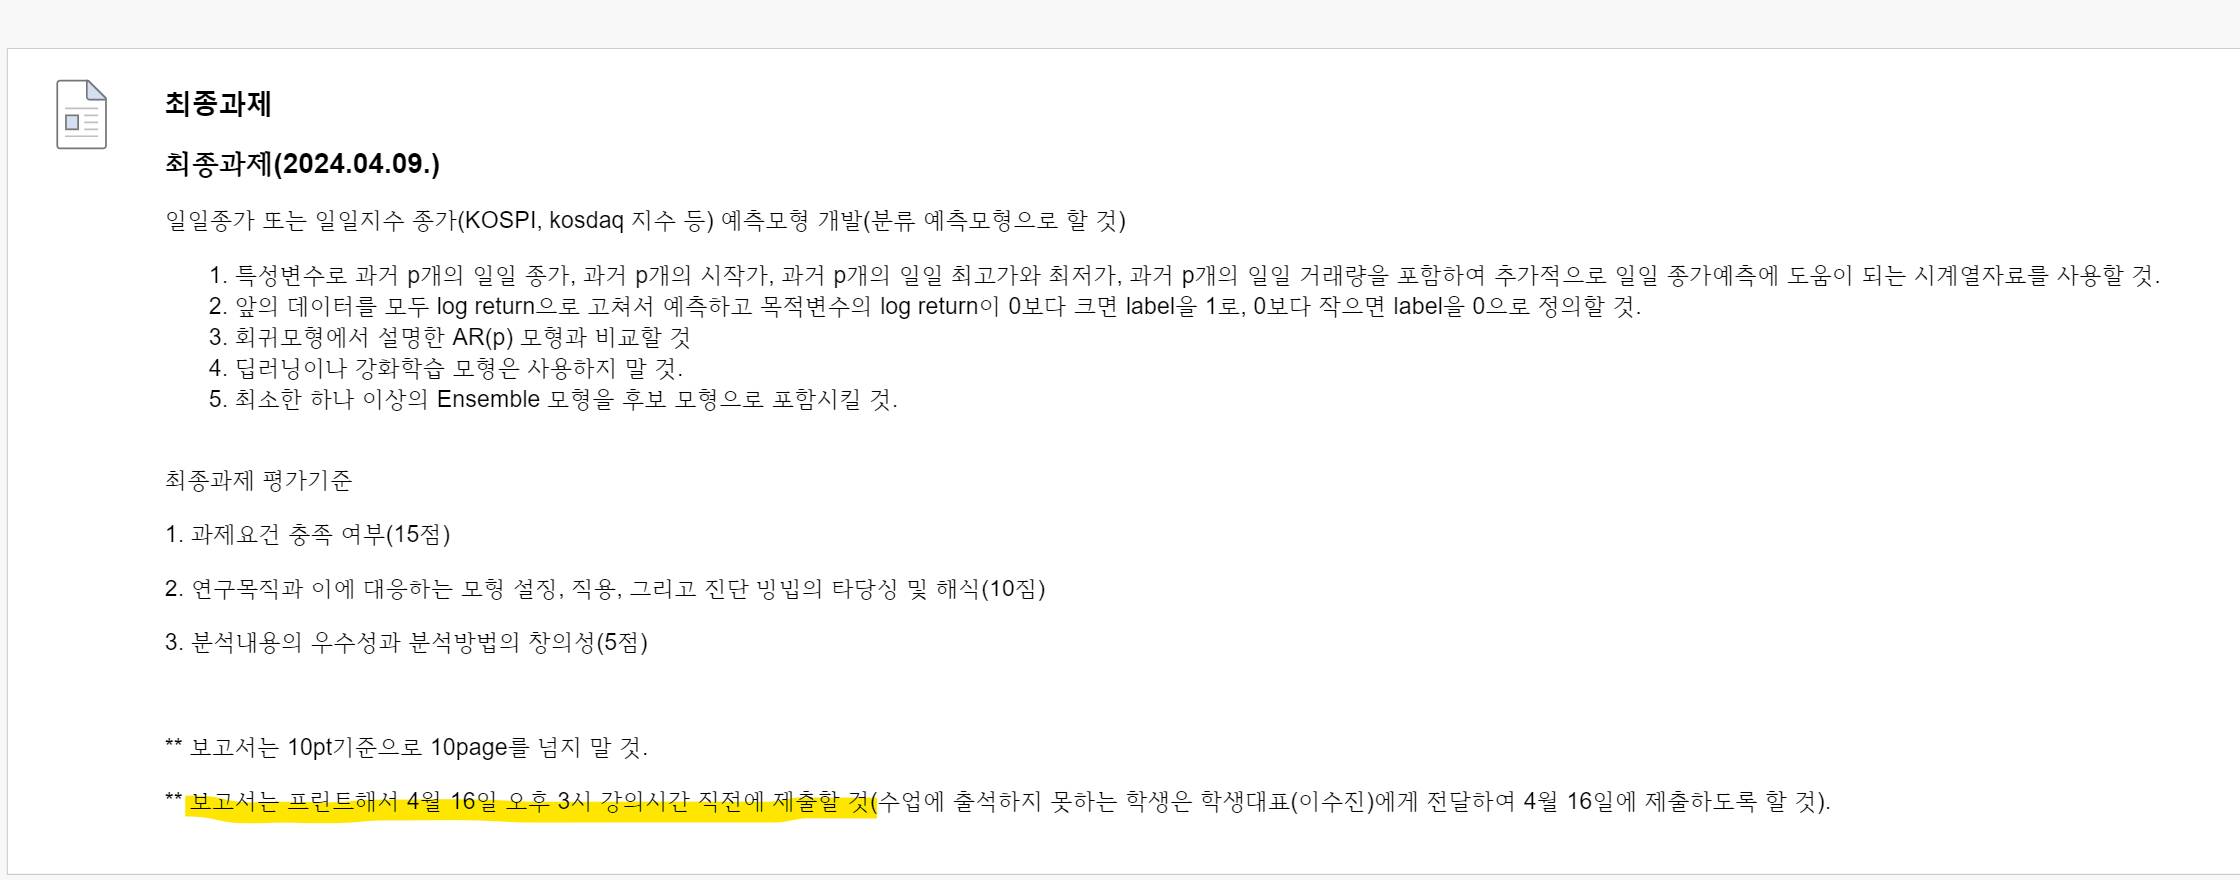

In [4]:
#pip install yfinance
#pip install pandas_datareader 
from pandas_datareader import data as pdr
import yfinance as yf
`yf.pdr_override()` is a function provided by the yfinance library that overrides the default data retrieval method used by pandas_datareader with the yfinance library. This allows you to use yfinance to directly fetch financial data instead of relying on the default data sources provided by pandas_datareader.
yf.pdr_override()

In [6]:
sec = pdr.get_data_yahoo('005930.KS',start = '2018-05-04') #삼성전자의 주식 분할이후데이터부터 조회종료일은 생략. 
sec.head(10) 

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-04,53000.0,53900.0,51800.0,51900.0,44157.507812,39565391
2018-05-08,52600.0,53200.0,51900.0,52600.0,44753.074219,23104720
2018-05-09,52600.0,52800.0,50900.0,50900.0,43306.691406,16128305
2018-05-10,51700.0,51700.0,50600.0,51600.0,43902.261719,13905263
2018-05-11,52000.0,52200.0,51200.0,51300.0,43647.015625,10314997
2018-05-14,51000.0,51100.0,49900.0,50100.0,42626.023438,14909272
2018-05-15,50200.0,50400.0,49100.0,49200.0,41860.296875,18709146
2018-05-16,49200.0,50200.0,49150.0,49850.0,42413.328125,15918683
2018-05-17,50300.0,50500.0,49400.0,49400.0,42030.457031,10365440


In [7]:
sec.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-28,79400.0,81000.0,79200.0,80800.0,80800.0,25084812
2024-03-29,81200.0,82500.0,80900.0,82400.0,82400.0,27126366
2024-04-01,83200.0,83300.0,82000.0,82000.0,82000.0,20116513
2024-04-02,82900.0,85000.0,82900.0,85000.0,85000.0,37077944
2024-04-03,84300.0,85000.0,83500.0,84100.0,84100.0,30493347
2024-04-04,85200.0,85500.0,84300.0,85300.0,85300.0,25248934
2024-04-05,84500.0,85000.0,83800.0,84500.0,84500.0,18883752
2024-04-08,85200.0,86000.0,84500.0,84500.0,84500.0,18953232
2024-04-09,84500.0,84900.0,83100.0,83600.0,83600.0,23725956


In [8]:
sec.index #datatime 으로 되어있음

DatetimeIndex(['2018-05-04', '2018-05-08', '2018-05-09', '2018-05-10',
               '2018-05-11', '2018-05-14', '2018-05-15', '2018-05-16',
               '2018-05-17', '2018-05-18',
               ...
               '2024-03-28', '2024-03-29', '2024-04-01', '2024-04-02',
               '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08',
               '2024-04-09', '2024-04-11'],
              dtype='datetime64[ns]', name='Date', length=1460, freq=None)

In [9]:
sec.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# 데이터 EDA 시각화

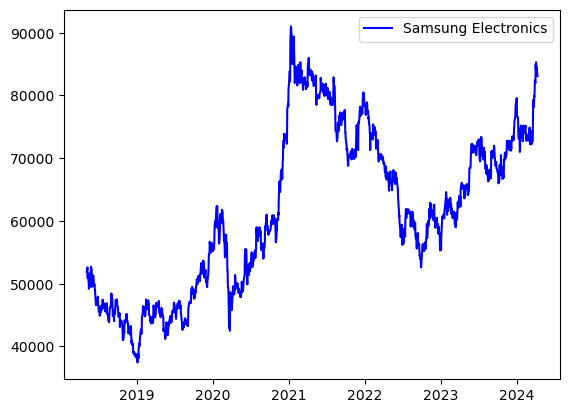

In [10]:

import matplotlib.pyplot as plt
plt.plot(sec.index,sec.Close,'b',label='Samsung Electronics')
plt.legend(loc='best')
plt.show()

## 일간 변동률 구하기 (전날대비 변동률 => 수익률 log return)

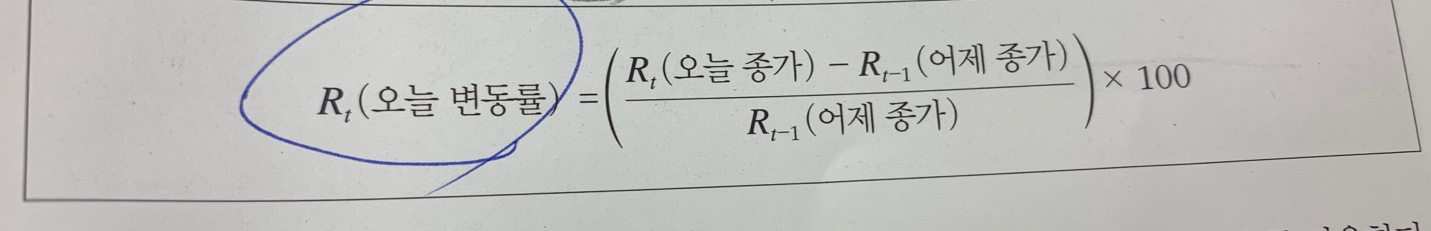

In [11]:

type(sec['Close'])

pandas.core.series.Series

In [12]:
sec['Close']

Date
2018-05-04    51900.0
2018-05-08    52600.0
2018-05-09    50900.0
2018-05-10    51600.0
2018-05-11    51300.0
               ...   
2024-04-04    85300.0
2024-04-05    84500.0
2024-04-08    84500.0
2024-04-09    83600.0
2024-04-11    83100.0
Name: Close, Length: 1460, dtype: float64

In [13]:
#t-1 종가 칼럼 만들기 (전 영업일 데이터 넣어주기, t를 예측하기 위해서)
#shift 함수를  써서 하나씩 밀기 n행 만큼 데이터가 밀어짐
sec['Close'].shift(1)

Date
2018-05-04        NaN
2018-05-08    51900.0
2018-05-09    52600.0
2018-05-10    50900.0
2018-05-11    51600.0
               ...   
2024-04-04    84100.0
2024-04-05    85300.0
2024-04-08    84500.0
2024-04-09    84500.0
2024-04-11    83600.0
Name: Close, Length: 1460, dtype: float64

In [15]:
sec_dpc = (sec['Close']/sec['Close'].shift(1)-1)*100 #위 수식 코드로 구현

sec_dpc.tail() #전날 대비 수익률

Date
2024-04-04    1.426873
2024-04-05   -0.937866
2024-04-08    0.000000
2024-04-09   -1.065089
2024-04-11   -0.598086
Name: Close, dtype: float64

In [16]:
sec_dpc.iloc[0] = 0 #첫 데이터가 밀리므로 일간 변동률 값이 NAN 인것을 0으로 변경
sec_dpc.head() #전날대비 수익률 컬럼 생성=> 라벨링해주기

Date
2018-05-04    0.000000
2018-05-08    1.348748
2018-05-09   -3.231939
2018-05-10    1.375246
2018-05-11   -0.581395
Name: Close, dtype: float64

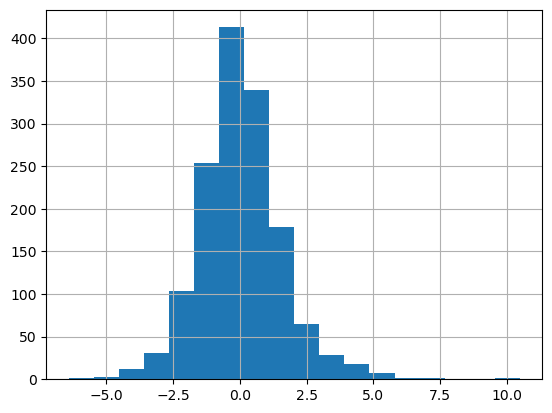

In [18]:
#데이터 분포의 시각화

import matplotlib.pyplot as plt
sec_dpc = (sec['Close']-sec['Close'].shift(1))/sec['Close'].shift(1)*100
sec_dpc.iloc[0] = 0
plt.hist(sec_dpc,bins=18)
plt.grid(True)
plt.show()

In [19]:
sec_dpc.describe()
#삼성전자의 조회기간 동안 평균 수익률 mean : 0.044547

count    1460.000000
mean        0.044547
std         1.572981
min        -6.387665
25%        -0.961064
50%         0.000000
75%         0.846953
max        10.470588
Name: Close, dtype: float64

In [20]:
sec_dpc

#칼럼명 log_return 추가

Date
2018-05-04    0.000000
2018-05-08    1.348748
2018-05-09   -3.231939
2018-05-10    1.375246
2018-05-11   -0.581395
                ...   
2024-04-04    1.426873
2024-04-05   -0.937866
2024-04-08    0.000000
2024-04-09   -1.065089
2024-04-11   -0.598086
Name: Close, Length: 1460, dtype: float64

### 다른 종목과 비교하고 싶다면..

In [ ]:
# sec = pdr.get_data_yahoo('005930.KS', start='2018-05-04')
# sec_dpc = (sec['Close']-sec['Close'].shift(1)) / sec['Close'].shift(1) * 100
# sec_dpc.iloc[0] = 0 # 일간 변동률의 첫 번째 값인 NaN을 0으로 변경한다.
# sec_dpc_cp = ((100+sec_dpc)/100).cumprod()*100-100 # 일간 변동률 누적곱 계산

# msft = pdr.get_data_yahoo('MSFT', start='2018-05-04')
# msft_dpc = (msft['Close'] / msft['Close'].shift(1) -1) * 100
# msft_dpc.iloc[0] = 0
# msft_dpc_cp = ((100+msft_dpc)/100).cumprod()*100-100
 
# import matplotlib.pyplot as plt
# plt.plot(sec.index, sec_dpc_cp, 'b', label='Samsung Electronics')
# plt.plot(msft.index, msft_dpc_cp, 'r--', label='Microsoft')
# plt.ylabel('Change %') 
# plt.grid(True)
# plt.legend(loc='best')
# plt.show()

### 일간 변동률 누적곱 계산

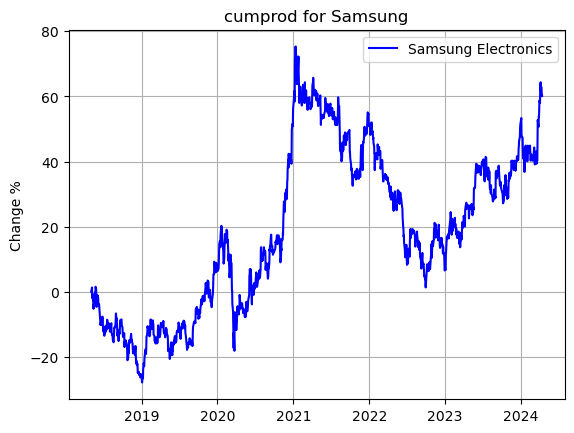

In [24]:
# 일간 변동률 누적곱 계산

sec_dpc_cp = ((100+sec_dpc)/100).cumprod()*100-100 # 일간 변동률 누적곱 계산
 
import matplotlib.pyplot as plt
plt.plot(sec.index, sec_dpc_cp, 'b', label='Samsung Electronics')
# plt.plot(msft.index, msft_dpc_cp, 'r--', label='Microsoft')
plt.ylabel('Change %') 
plt.grid(True)
plt.legend(loc='best')
plt.title("cumprod for Samsung")
plt.show()